In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.metrics import classification_report            # Summary of classifier performance

from utils import get_df, evaluate_classifier

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Barley',
    'Vinterbyg': 'Barley',
    'Grønkorn af vårbyg': 'Barley',
    'Vårbyg, helsæd': 'Barley',
    'Vinterhvede': 'Wheat',
    'Vårhvede': 'Wheat',
    'Vinterhybridrug': 'Rye',
    'Vårhavre': 'Oat',
    'Silomajs': 'Maize',
    'Majs til modenhed': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Sukkerroer til fabrik': 'Sugarbeet',
    'Permanent græs, normalt udbytte': 'Grass',
    'Skovdrift, alm.': 'Forest',
    'Juletræer og pyntegrønt på landbrugsjord': 'Forest'
}

RANDOM_SEED = 42

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 67312, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 62131272 63199619
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 222 ms


In [5]:
ds.close()

time: 38.8 ms


In [6]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 11.5 s


In [7]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2019-01-01', '2019-10-01'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    df_polarization = df_polarization.reset_index()  # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 15.9 s


In [8]:
#df_sklearn

time: 21 ms


In [9]:
#df_sklearn[df_sklearn['afgkode'] == 252].describe()

time: 19.8 ms


In [10]:
#df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
#                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]

df_sklearn_remapped = df_sklearn.copy()

df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1
    
    #df_sklearn = df_sklearn.replace(key, value)
    
for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
print(f"Crop types: {class_names}")

Crop types: ['Potato', 'Barley', 'Wheat', 'Rye', 'Oat', 'Maize', 'Rapeseed', 'Sugarbeet', 'Grass', 'Forest']
time: 284 ms


In [11]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

time: 547 ms


In [12]:
# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      38514
Test samples:       16506
Number of features: 135
time: 48.9 ms


Training time: 11.5108 s
Prediction time: 0.0042 s

Report:

Train accuracy: 1.0
Test accuracy: 0.8219

               precision    recall  f1-score   support

      Potato       0.94      0.94      0.94      2140
      Barley       0.79      0.78      0.79      4478
       Wheat       0.77      0.77      0.77      1605
         Rye       0.92      0.92      0.92      1376
         Oat       0.70      0.71      0.71      1358
       Maize       0.88      0.88      0.88      1672
    Rapeseed       0.97      0.98      0.97      1078
   Sugarbeet       0.53      0.40      0.45        25
       Grass       0.61      0.59      0.60      1197
      Forest       0.82      0.85      0.84      1577

    accuracy                           0.82     16506
   macro avg       0.79      0.78      0.79     16506
weighted avg       0.82      0.82      0.82     16506



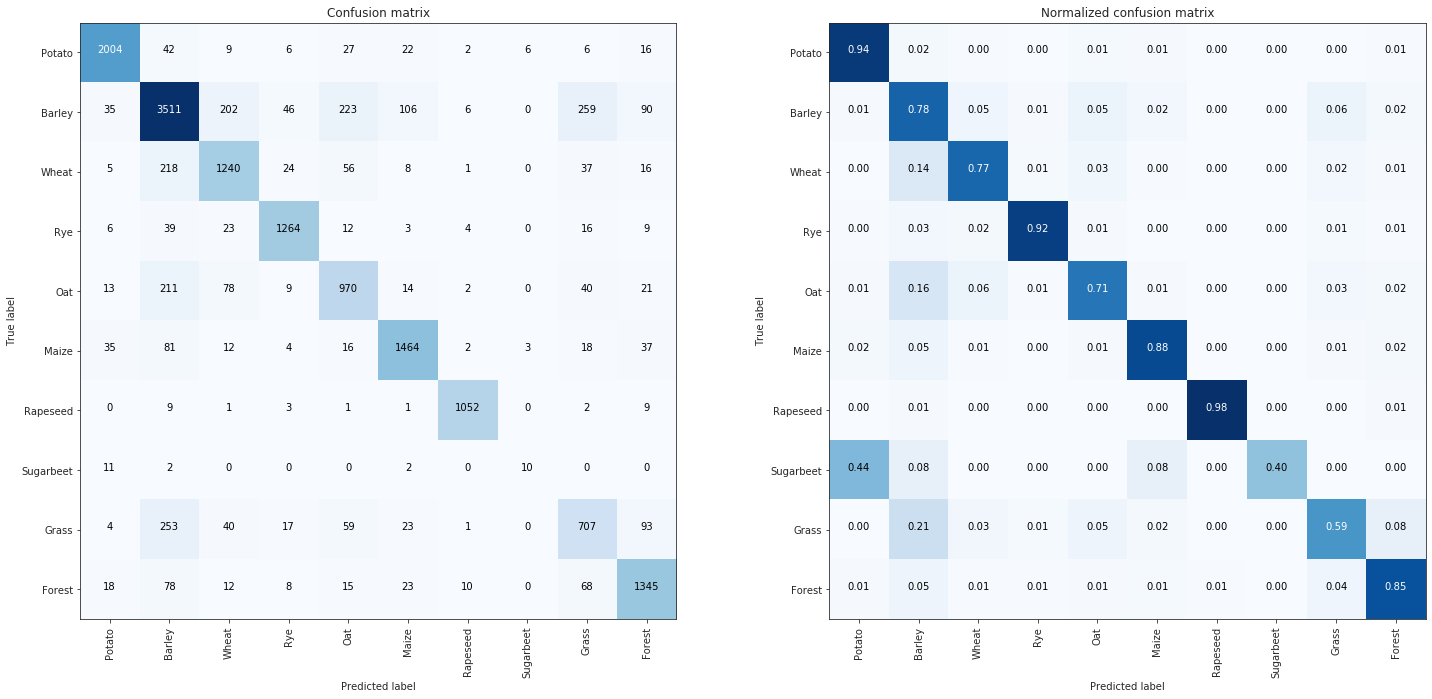

time: 12.5 s


In [194]:
from sklearn.tree import DecisionTreeClassifier              

# Instantiate and evaluate classifier
clf = DecisionTreeClassifier()
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=False)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 2.1206 s
Prediction time: 0.0043 s

Report:

Train accuracy: 0.8817
Test accuracy: 0.8685

               precision    recall  f1-score   support

      Potato       0.96      0.96      0.96      2140
      Barley       0.80      0.85      0.82      4478
       Wheat       0.84      0.76      0.80      1605
         Rye       0.96      0.96      0.96      1376
         Oat       0.85      0.75      0.80      1358
       Maize       0.92      0.95      0.93      1672
    Rapeseed       0.99      0.99      0.99      1078
   Sugarbeet       0.94      0.68      0.79        25
       Grass       0.71      0.71      0.71      1197
      Forest       0.89      0.90      0.89      1577

    accuracy                           0.87     16506
   macro avg       0.89      0.85      0.87     16506
weighted avg       0.87      0.87      0.87     16506



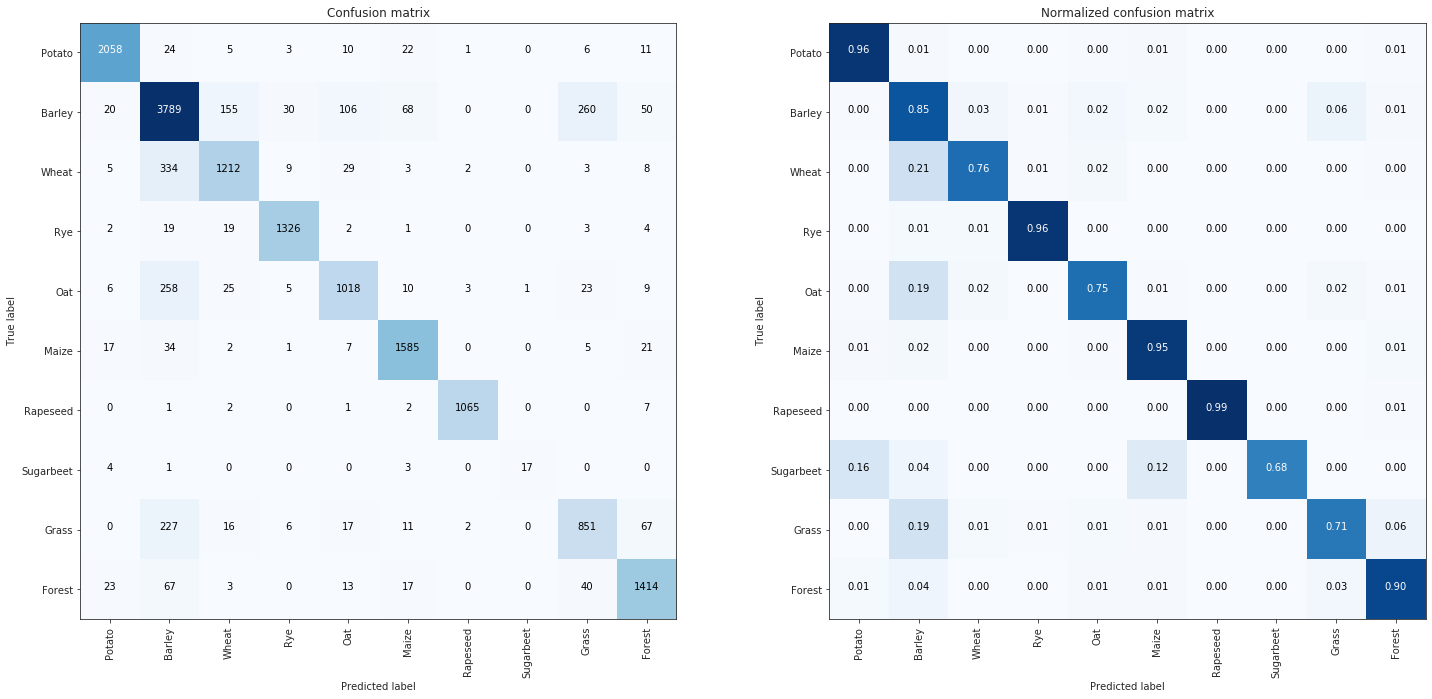

time: 3.33 s


In [195]:
from sklearn.linear_model import LogisticRegression          

# Instantiate classifier.
#clf = LogisticRegression(solver='newton-cg', max_iter=1000)
clf = LogisticRegression()

# Evaluate classifier without feature scaling
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training time: 67.2004 s
Prediction time: 0.0126 s

Report:

Train accuracy: 0.95
Test accuracy: 0.9066

               precision    recall  f1-score   support

      Potato       0.98      0.97      0.97      2140
      Barley       0.88      0.88      0.88      4478
       Wheat       0.91      0.90      0.90      1605
         Rye       0.96      0.96      0.96      1376
         Oat       0.88      0.81      0.85      1358
       Maize       0.93      0.95      0.94      1672
    Rapeseed       0.99      0.99      0.99      1078
   Sugarbeet       1.00      0.72      0.84        25
       Grass       0.73      0.79      0.76      1197
      Forest       0.91      0.92      0.91      1577

    accuracy                           0.91     16506
   macro avg       0.92      0.89      0.90     16506
weighted avg       0.91      0.91      0.91     16506



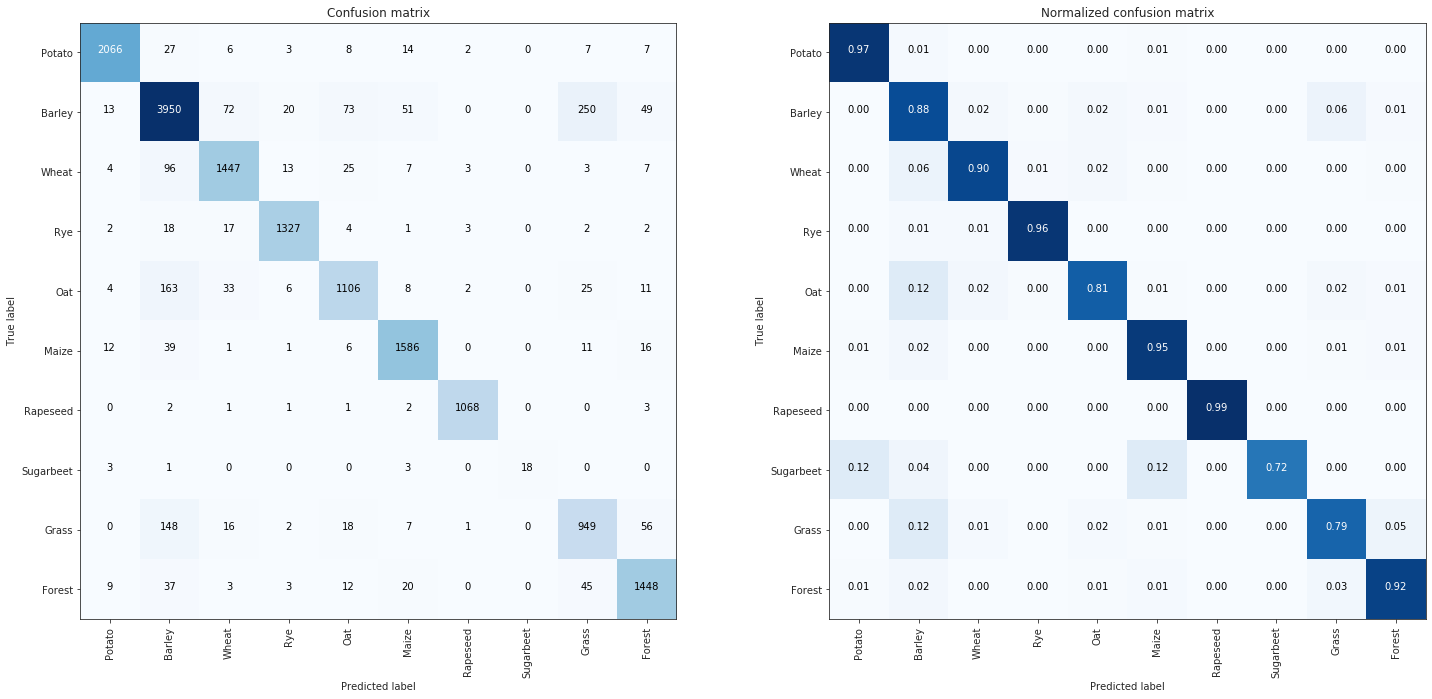

time: 1min 8s


In [196]:
from sklearn.neural_network import MLPClassifier

# Instantiate and evaluate classifier
clf = MLPClassifier(solver='lbfgs', alpha=10, hidden_layer_sizes=(25, 25), max_iter=1000)  # See what happens when you change random state
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

Training time: 130.4262 s
Prediction time: 22.2756 s

Report:

Train accuracy: 0.8942
Test accuracy: 0.8777

               precision    recall  f1-score   support

      Potato       0.97      0.97      0.97      2140
      Barley       0.80      0.86      0.83      4478
       Wheat       0.89      0.74      0.81      1605
         Rye       0.97      0.96      0.96      1376
         Oat       0.89      0.75      0.81      1358
       Maize       0.93      0.95      0.94      1672
    Rapeseed       0.99      0.99      0.99      1078
   Sugarbeet       0.95      0.80      0.87        25
       Grass       0.72      0.79      0.75      1197
      Forest       0.91      0.90      0.90      1577

    accuracy                           0.88     16506
   macro avg       0.90      0.87      0.88     16506
weighted avg       0.88      0.88      0.88     16506



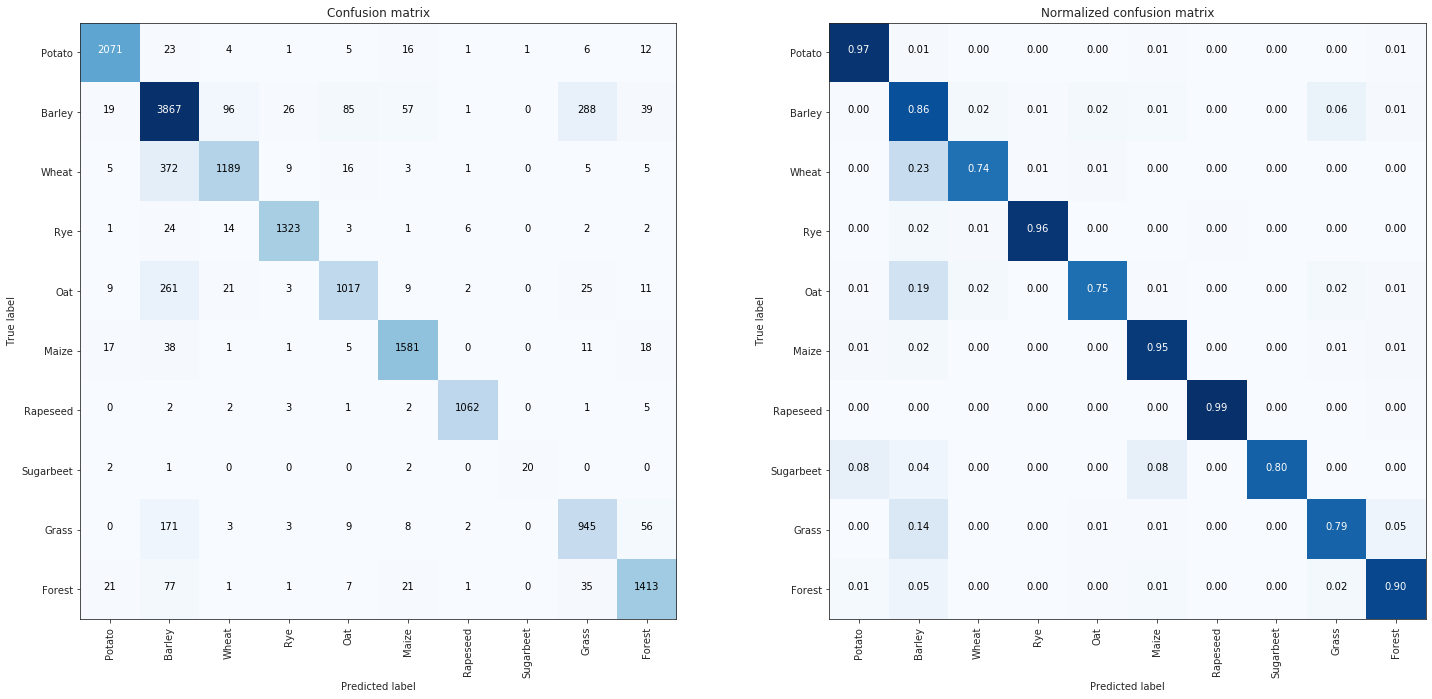

time: 3min 47s


In [197]:
from sklearn.svm import SVC   

# Instantiate and evaluate classifier
clf = SVC(kernel='linear')
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

Training time: 61.5846 s
Prediction time: 28.8207 s

Report:

Train accuracy: 0.9438
Test accuracy: 0.9184

               precision    recall  f1-score   support

      Potato       0.98      0.97      0.97      2140
      Barley       0.88      0.90      0.89      4478
       Wheat       0.95      0.87      0.91      1605
         Rye       0.98      0.97      0.98      1376
         Oat       0.94      0.81      0.87      1358
       Maize       0.94      0.96      0.95      1672
    Rapeseed       1.00      0.99      0.99      1078
   Sugarbeet       1.00      0.80      0.89        25
       Grass       0.75      0.88      0.81      1197
      Forest       0.94      0.92      0.93      1577

    accuracy                           0.92     16506
   macro avg       0.93      0.91      0.92     16506
weighted avg       0.92      0.92      0.92     16506



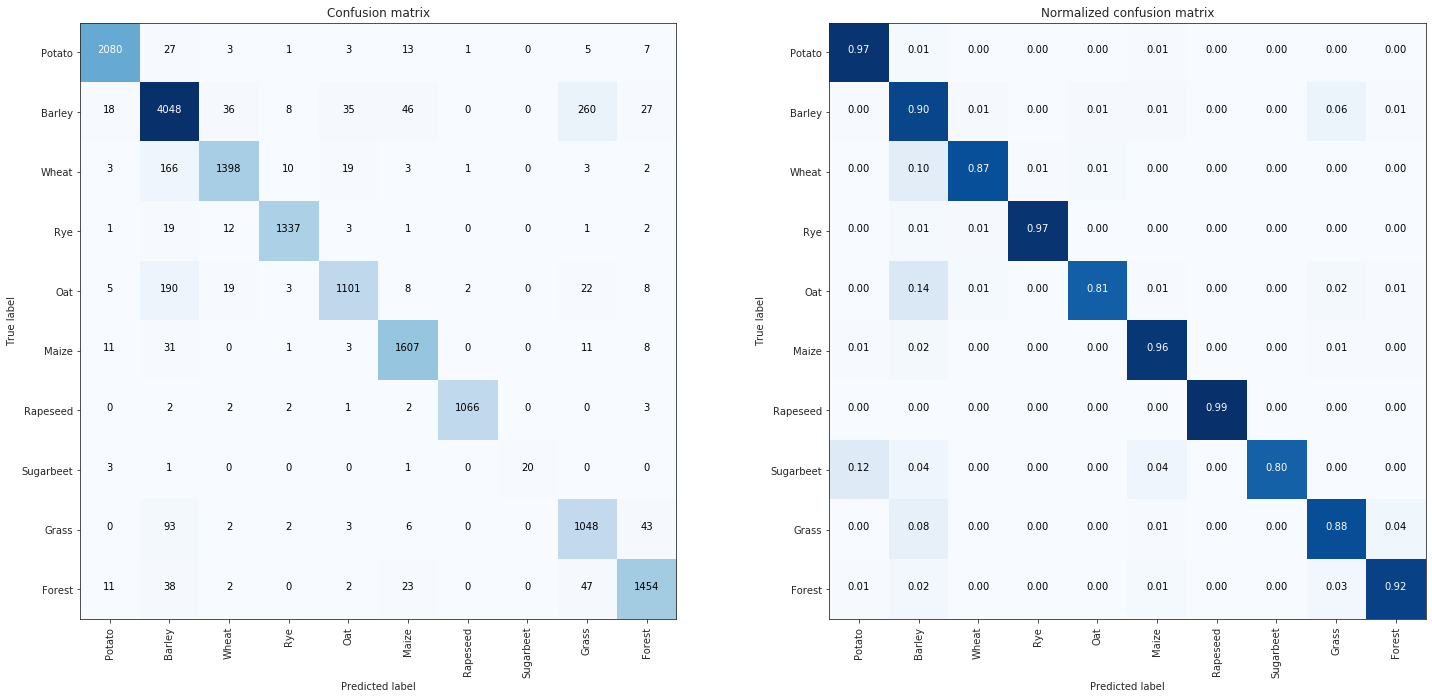

time: 3min 7s


In [198]:
# Instantiate and evaluate classifier
clf = SVC(kernel='rbf')
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

In [1]:
try:  # If auto-sklearn is installed 
    import autosklearn.classification
except:  # Else install auto-sklearn (https://automl.github.io/auto-sklearn/master/installation.html and https://hub.docker.com/r/alfranz/automl/dockerfile) 
    !sudo apt-get update && sudo apt-get install -y swig curl
    !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install --default-timeout=100
    !pip install auto-sklearn

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]      
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [44.6 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [8,213 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [839 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [889 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic/restricted amd64 Packages [13.5 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1,344 kB]  
Get:12 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:13 http://archiv

[WARNING] [2020-04-20 08:29:18,698:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 08:29:18,738:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 08:29:20,766:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 08:37:23,681:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] Memory Exception -- restart with less ensemle_nbest: 25
[WARNING] [2020-04-20 09:26:08,550:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2020-04-20 09:26:08,550:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


Process Process-11:
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 996, in fit
    load_models=load_models,
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/smbo.py", line 513, in run_smbo
    logger=smac.solver.logger,
  File "/opt/conda/lib/python3.7/site-packages/smac/o

Training time: 4084.1965 s
Prediction time: 8.4063 s

Report:

Train accuracy: 0.9691
Test accuracy: 0.9113

               precision    recall  f1-score   support

      Potato       0.99      0.97      0.98      2325
      Barley       0.88      0.89      0.88      4398
       Wheat       0.96      0.87      0.91      1586
         Rye       0.98      0.96      0.97      1436
         Oat       0.91      0.82      0.86      1328
       Maize       0.91      0.96      0.94      1631
    Rapeseed       0.99      0.99      0.99      1078
   Sugarbeet       1.00      0.68      0.81        22
       Grass       0.70      0.85      0.77      1145
      Forest       0.92      0.90      0.91      1557

    accuracy                           0.91     16506
   macro avg       0.92      0.89      0.90     16506
weighted avg       0.92      0.91      0.91     16506



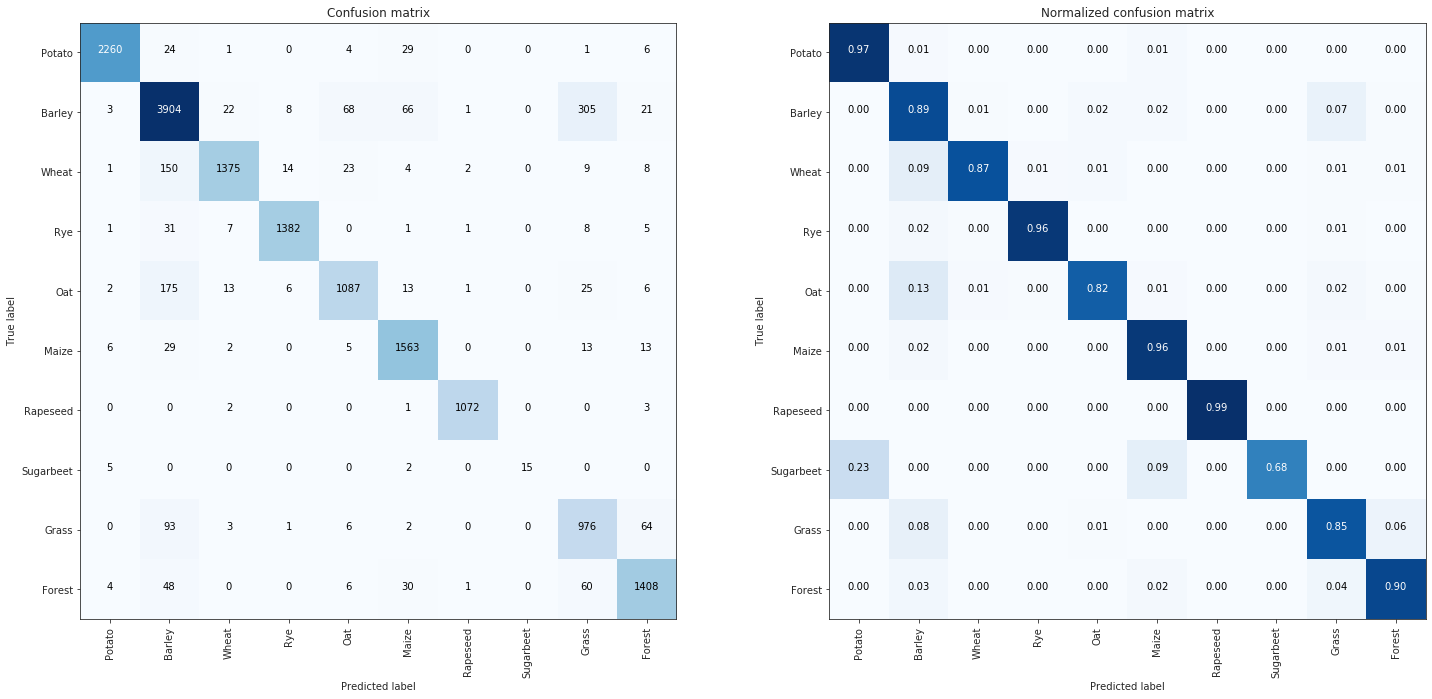

time: 1h 8min 40s


In [13]:
import autosklearn.classification

# Instantiate and evaluate classifier
#clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, 
#                                                       ml_memory_limit=4096, n_jobs=12,  resampling_strategy='cv',
#                                                       resampling_strategy_arguments={'folds': 5},)
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, 
                                                       ml_memory_limit=32768, n_jobs=24)
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=True)

# Then train the ensemble on the whole training dataset
# https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html#sphx-glr-examples-example-crossvalidation-py

In [17]:
import autosklearn.classification

# Instantiate and evaluate classifier
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, 
                                                       ml_memory_limit=32768, n_jobs=24,  resampling_strategy='cv',
                                                       resampling_strategy_arguments={'folds': 10},)
#clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, 
#                                                       ml_memory_limit=32768, n_jobs=24)
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, auto_sklearn_crossvalidation=True)

# Then train the ensemble on the whole training dataset
# https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html#sphx-glr-examples-example-crossvalidation-py

[WARNING] [2020-04-20 09:58:43,716:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 09:58:43,756:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 09:58:45,809:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 09:58:47,840:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 09:58:49,867:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 09:58:51,875:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 09:58:53,885:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than

In [18]:
import autosklearn.classification

# Instantiate and evaluate classifier
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=7200, per_run_time_limit=360, 
                                                       ml_memory_limit=32768, n_jobs=24,  resampling_strategy='cv',
                                                       resampling_strategy_arguments={'folds': 5},)
#clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, 
#                                                       ml_memory_limit=32768, n_jobs=24)
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, auto_sklearn_crossvalidation=True)

# Then train the ensemble on the whole training dataset
# https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html#sphx-glr-examples-example-crossvalidation-py

[WARNING] [2020-04-20 11:21:18,802:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 11:21:19,029:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 11:21:21,059:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 11:21:23,083:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 11:21:25,099:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 11:21:27,121:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 11:21:29,151:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than

In [19]:
#clf_trained.show_models()

time: 30.6 ms


In [20]:
import autosklearn.classification

# Instantiate and evaluate classifier
clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=7200, per_run_time_limit=720, 
                                                       ml_memory_limit=32768, n_jobs=24,  resampling_strategy='cv',
                                                       resampling_strategy_arguments={'folds': 5},)
#clf = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=3600, per_run_time_limit=360, 
#                                                       ml_memory_limit=32768, n_jobs=24)
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, auto_sklearn_crossvalidation=True)

# Then train the ensemble on the whole training dataset
# https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html#sphx-glr-examples-example-crossvalidation-py

[WARNING] [2020-04-20 13:51:50,612:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 13:51:50,710:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 13:51:52,751:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 13:51:54,778:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 13:51:56,806:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 13:51:58,838:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than random - using Dummy Score!
[WARNING] [2020-04-20 13:52:00,868:EnsembleBuilder(1791095845):718cac041acd2d8f60e4586c9e9a3876] No models better than

Process pynisher function call:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/ensemble_builder.py", line 234, in main
    time.sleep(self.sleep_duration)
KeyboardInterrupt
Process pynisher function call:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_fu

KeyboardInterrupt: 

  File "/opt/conda/lib/python3.7/site-packages/smac/facade/smac_facade.py", line 400, in optimize
    incumbent = self.solver.run()
  File "/opt/conda/lib/python3.7/site-packages/smac/optimizer/smbo.py", line 165, in run
    self.start()


time: 3min 28s


  File "/opt/conda/lib/python3.7/site-packages/smac/optimizer/smbo.py", line 138, in start
    self.incumbent = self.initial_design.run()
  File "/opt/conda/lib/python3.7/site-packages/smac/initial_design/single_config_initial_design.py", line 86, in run
    "0"))
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/evaluation/__init__.py", line 170, in start
    capped=capped)
  File "/opt/conda/lib/python3.7/site-packages/smac/tae/execute_ta_run.py", line 168, in start
    instance_specific=instance_specific)
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/evaluation/__init__.py", line 258, in run
    info = autosklearn.evaluation.util.read_queue(queue)
  File "/opt/conda/lib/python3.7/site-packages/autosklearn/evaluation/util.py", line 13, in read_queue
    rval = queue_.get(timeout=1)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 257

In [22]:
# Take a look at https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29
from sklearn.svm import SVC   
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf']}
#grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=20, n_jobs=32)
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=20, n_jobs=32)
grid_trained, _ = evaluate_classifier(grid, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 tasks      | elapsed: 17.5min
[Parallel(n_jobs=32)]: Done   2 tasks      | elapsed: 17.7min
[Parallel(n_jobs=32)]: Done   3 tasks      | elapsed: 18.1min
[Parallel(n_jobs=32)]: Done   4 tasks      | elapsed: 18.2min
[Parallel(n_jobs=32)]: Done   5 tasks      | elapsed: 18.4min
[Parallel(n_jobs=32)]: Done   6 tasks      | elapsed: 22.6min
[Parallel(n_jobs=32)]: Done   7 tasks      | elapsed: 23.7min
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed: 24.1min
[Parallel(n_jobs=32)]: Done   9 tasks      | elapsed: 24.7min
[Parallel(n_jobs=32)]: Done  10 tasks      | elapsed: 24.8min
[Parallel(n_jobs=32)]: Done  11 tasks      | elapsed: 32.3min
[Parallel(n_jobs=32)]: Done  12 tasks      | elapsed: 32.7min
[Parallel(n_jobs=32)]: Done  13 tasks      | elapsed: 33.0min
[Parallel(n_jobs=32)]: Done  14 tasks      | elapsed: 33.2min
[Parallel(n_jobs=32)]: Done  15 tasks      | elapsed: 3

KeyboardInterrupt: 

time: 2h 12min 32s
